# 5조 결과 코드 

- 김성우 (12171470)
- 이준영 (12171455)

## Model
- Squeezeformer (2022)
- Kim, S., Gholami, A., Shaw, A., Lee, N., Mangalam, K., Malik, J., ... & Keutzer, K. (2022). Squeezeformer: An Efficient Transformer for Automatic Speech Recognition. arXiv preprint [arXiv:2206.00888](https://arxiv.org/abs/2206.00888).

# 1. 어떤 gpu 연결됐는지 리소스 확인하기

In [38]:
!nvidia-smi

Mon Dec 12 12:51:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    28W /  70W |   6404MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [39]:
%matplotlib inline

# 3. Configuration 셋팅
- 이전에 학습하다 끊긴거 더 학습해보고 싶은 경우에 학습하던 모델의 `saved_json`, `saved_weight`, `training_id`, `start_epoch`설정해두기
## 그리고 notion에 설정 기록할것
## + 각 training 세션별로 id 생성해서 구분하기로 함. id는 컴퓨터의 현재시간으로 정함.

In [40]:
from pytz import timezone
from datetime import datetime


class Condfiguration():
    def __init__(self):
        # self.seed = 1234                # random seed
        self.seed = None                # random seed

        ####################### 새로 다시시작하는 경우 ########################
        self.saved_json = None
        self.last_model = None
        self.best_loss_model = None
        self.best_cer_model = None

        self.training_id = datetime.now(timezone('Asia/Seoul')).strftime('%m%d%H%M%S')
        self.start_epoch = 1
        #######################################################################

        # Audio feature parameter
        self.sample_rate = 16000
        self.set_spec_params(win_ms=20, overlap_ratio=0.25)
        self.power = 2
        self.feature_type = 'mfcc'      # 'melspec', 'mfcc'
        self.window_type = 'hamming'    # 'hamming', 'han','kaiser' 
        self.n_mels = 40                # 26, 40 ...
        
        # hyperparameter for training
        self.batch_size = 64            # batch size in training # 16,32,64,128,256
        self.lr = 1e-4                  # learning rate 0.001, 0.0005, 0.0001
        self.CER_TOLERANCE = 20
        self.LOSS_TOLERANCE = 10
        self.min_len = 2
        self.max_len = 8                # maximum characters of sentence
        self.weight_decay = 5e-5
        self.max_epoch = 100
        self.batch_size_test = 2**10
        self.model_name = "Squeezeformer-M"

        # Squeezeformer-M parameters
        self.input_dim = self.n_mels//2 if self.feature_type=="mfcc" else self.n_mels
        self.encoder_dim = 324
        self.num_encoder_layers = 20
        self.num_attention_heads = 4
        self.feed_forward_expansion_factor = 4
        self.conv_expansion_factor = 2
        self.input_dropout_p = 0.1
        self.feed_forward_dropout_p = 0.1 
        self.attention_dropout_p = 0.1
        self.conv_dropout_p = 0.1
        self.conv_kernel_size = 31
        self.half_step_residual = True

        # label
        self.SOS_token = None
        self.EOS_token = None
        self.PAD_token = None
        self.char2index = {}
        self.index2char = {}


    def set_spec_params(self, win_ms, overlap_ratio):
        """
        win_ms - 윈도우 사이즈를 ms로 나타낸걸 parameter로 받았음.
        overlap_ratio - 윈도우가 이동하면서 겹쳐지는 비율
        """
        nfft_candidates = [2**i for i in range(11)]
        self.win_length = int(win_ms*self.sample_rate/1000)
        self.hop_length = int(self.win_length*overlap_ratio)
        for nfft_candidate in nfft_candidates:
            if self.win_length <= nfft_candidate:
                self.n_fft = nfft_candidate
                break

config = Condfiguration()

print(config.win_length)
print(config.hop_length)
print(config.n_fft)

print(config.training_id)

320
80
512
1212215117


# 2. 구글 드라이브 연결 (제출시에는 주석처리)


In [41]:
import os

SAVE_PATH = f'/content/{config.training_id}'
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)
get_save_path = lambda filename : os.path.join(SAVE_PATH, filename)
SAVE_PATH

'/content/1212215117'

In [42]:
with open(get_save_path("config.txt"), "w") as f:
    f.write("model_name : {}\n".format(config.model_name))
    f.write("batch_size : {}\n".format(config.batch_size))
    f.write("lr : {}\n".format(config.lr))
    f.write("weight_decay : {}\n".format(config.weight_decay))
    f.write("############### model param ################\n")
    f.write("input_dim : {}\n".format(config.input_dim))
    f.write("encoder_dim : {}\n".format(config.encoder_dim))
    f.write("num_encoder_layers : {}\n".format(config.num_encoder_layers))
    f.write("num_attention_heads : {}\n".format(config.num_attention_heads))
    f.write("feed_forward_expansion_factor : {}\n".format(config.feed_forward_expansion_factor))
    f.write("conv_expansion_factor : {}\n".format(config.conv_expansion_factor))
    f.write("input_dropout_p : {}\n".format(config.input_dropout_p))
    f.write("feed_forward_dropout_p : {}\n".format(config.feed_forward_dropout_p))
    f.write("attention_dropout_p : {}\n".format(config.attention_dropout_p))
    f.write("conv_dropout_p : {}\n".format(config.conv_dropout_p))
    f.write("conv_kernel_size : {}\n".format(config.conv_kernel_size))
    f.write("half_step_residual : {}\n".format(config.half_step_residual))
    f.write("############### audio feature param ################\n")
    f.write("feature_type : {}\n".format(config.feature_type))
    f.write("window_type : {}\n".format(config.window_type))
    f.write("n_mels : {}\n".format(config.n_mels))
    f.write("win_length : {}\n".format(config.win_length))
    f.write("hop_length : {}\n".format(config.hop_length))
    f.write("n_fft : {}\n".format(config.n_fft))

# Libraries 

In [43]:
######################### 제출시 주석 해제 ####################################
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install python-Levenshtein
!pip install wavio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
#-*- coding: utf-8 -*-

import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
from typing import Tuple, Union, Dict, Optional

import Levenshtein as Lev 

import sys
import os, glob
import random
import pickle, json
import copy

import numpy as np
import librosa
import scipy.signal
# import wavio
import wave
import math
import time

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Set random seed

In [45]:
if config.seed:
    random.seed(config.seed) 
    torch.manual_seed(config.seed) 
    torch.cuda.manual_seed_all(config.seed)

# Dataset

## importing dataset

이번 프로젝트에서 사용하는 데이터 셋은 `SpeechCommands <https://arxiv.org/abs/1804.03209>`입니다. 35개의 1초 길이(16kHz,16000 time frames)의 발화 명령으로 이루어져 있습니다.

- 명령어 종류가 35가지라는 뜻!

torchaudio가 데이터 로딩과 벡터로의 변환을 담당합니다. 직접 오디오 파일을 받고 싶다면, ``torchaudio.load()`` 를 사용하면 됩니다. 

아래는 데이터 셋을 훈련 데이터, 평가 데이터, 시험 데이터로 나누는 코드 입니다. CER 점수는 시험 데이터(test_set)로만 반영합니다. 

In [46]:
from torchaudio.datasets import SPEECHCOMMANDS

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: Union[str,None] = None):
        super().__init__('.', download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]


        if subset == "validation":
            self._walker = load_list("validation_list.txt")

        elif subset == "testing":
            self._walker = load_list("testing_list.txt")

        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt") # 이거 빼고 다 훈련 데이터 셋!
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# 데이터 셋 생성
train_set = SubsetSC("training")        # 훈련용
valid_set = SubsetSC("validation") # 파라미터 조정용 
test_set = SubsetSC("testing")          # 최종 평가

# 데이터 셋 길이 
print("training set : ",len(train_set),"\nvalidation set : ",len(valid_set),"\ntest set : ",len(test_set))

# 데이터 정보 저장
waveform, sample_rate, *_ = train_set[0]

training set :  105829 
validation set :  9981 
test set :  11005


## label 확인

In [47]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
# labels = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
print(labels)
print("전레 라벨 개수 >> ", len(labels))

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
전레 라벨 개수 >>  35


# Tockenizing

학습을 위해서는 라벨을 모두 숫자로 바꿔야 합니다. 라벨에 쓰이는 모든 글자들을 모아서 숫자에 대응 시키는 과정을 Tockenizing 이라고 합니다. 아래 `load_label`은 Tockenizing 후 인덱스와 텍스트로 변환이 가능하도록 하는 딕셔너리를 반환합니다. 

In [48]:
def sort_target(x):
    return x[1]

def load_label(label_list):
    char2index = {'<pad>':0, '<unk>':1, '<sos>':2, '<eos>':3}
    index2char = {0:'<pad>', 1:'<unk>', 2:'<sos>', 3:'<eos>'}
    char_count = {}

    print(label_list)

    for label in tqdm(label_list): # 리스트에서 라벨 하나 받기

        for char in label:        # 받은 라벨에서 글자 하나 받기 
            try:                  # 이전에 이미 진행한 글자인 경우 count, 처음 진행하는 경우 오류 발생하여 except으로 이동
                char_count[char] += 1

            except:               # 처음 받는 글자의 경우, 초기화 
                char_count[char] = 1

    # 글자 많이 나온 순서대로 sort
    char_count = dict(sorted(char_count.items(), key=sort_target, reverse=True))

    # 저장된 순서대로 인덱스 부여
    for i, char in enumerate(list(char_count.keys())):
        char2index[char]=i+4
        index2char[i+4]=char

    return char2index, index2char

char2index, index2char =load_label(labels)

config.char2index =char2index
config.index2char =index2char

config.SOS_token = char2index['<sos>']
config.EOS_token = char2index['<eos>']
config.PAD_token = char2index['<pad>']

label_length = len(index2char) # 출력 길이 

print("char2index",config.char2index)
print("index2char",config.index2char)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


  0%|          | 0/35 [00:00<?, ?it/s]

char2index {'<pad>': 0, '<unk>': 1, '<sos>': 2, '<eos>': 3, 'e': 4, 'o': 5, 'r': 6, 'a': 7, 'i': 8, 'n': 9, 't': 10, 'w': 11, 'f': 12, 's': 13, 'd': 14, 'h': 15, 'l': 16, 'g': 17, 'v': 18, 'u': 19, 'p': 20, 'b': 21, 'c': 22, 'y': 23, 'k': 24, 'm': 25, 'x': 26, 'z': 27}
index2char {0: '<pad>', 1: '<unk>', 2: '<sos>', 3: '<eos>', 4: 'e', 5: 'o', 6: 'r', 7: 'a', 8: 'i', 9: 'n', 10: 't', 11: 'w', 12: 'f', 13: 's', 14: 'd', 15: 'h', 16: 'l', 17: 'g', 18: 'v', 19: 'u', 20: 'p', 21: 'b', 22: 'c', 23: 'y', 24: 'k', 25: 'm', 26: 'x', 27: 'z'}


# util functions

## save_fig, loadjson, writejson

In [49]:
def argmin(a):
    b = [(i, n) for i,n in enumerate(a)]
    b = sorted(b,key=lambda x: x[1])
    return b[0]

def save_fig(objs,labels, path):
    for obj,label in zip(objs,labels):
        plt.plot(obj,label=label)
    idx, value = argmin(objs[1])
    plt.legend()
    plt.title(f"min: {value} @ epoch: {idx}/{len(objs[1])}")
    plt.savefig(path)
    plt.close()

def loadjson(path) -> Dict:
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

def writejson(path, json_dict: dict) -> None:
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(json_dict, f, ensure_ascii=False, indent=4)

## label to string

In [50]:
#label_to_string
def label_to_string_hyp(labels):
    SWITCH = False
    if len(labels.shape) == 1:
        sent = str()
        for i in labels:
            if i.item() == config.EOS_token:
                break
            if i.item() == config.PAD_token: # pad 토큰이 나오는 경우는 그냥 넘어간다!!!!!
                SWITCH = False
                continue
            if len(sent)>0 and i.item() == sent[-1] and SWITCH:
                continue
            sent += config.index2char[i.item()]
            SWITCH = True
        return sent

    elif len(labels.shape) == 2:
        sents = list()
        for i in labels:
            sent = str()
            for j in i:
                if j.item() == config.EOS_token:
                    break
                if j.item() == config.PAD_token:
                    SWITCH = False
                    continue
                if len(sent)>0 and j.item() == sent[-1] and SWITCH:
                    continue
                sent += config.index2char[j.item()]
            sents.append(sent)

        return sents

#label_to_string
def label_to_string(labels):
    if len(labels.shape) == 1:
        sent = str()
        for i in labels:
            if i.item() == config.EOS_token:
                break
            if i.item() == config.PAD_token: # pad 토큰이 나오는 경우는 그냥 넘어간다!!!!!
                continue
            sent += config.index2char[i.item()]
        return sent

    elif len(labels.shape) == 2:
        sents = list()
        for i in labels:
            sent = str()
            for j in i:
                if j.item() == config.EOS_token:
                    break
                if j.item() == config.PAD_token:
                    continue
                sent += config.index2char[j.item()]
            sents.append(sent)

        return sents

## char_distance, get_distance (CER 계산)

In [51]:
def char_distance(ref, hyp):
    ref = ref.replace(' ', '') 
    hyp = hyp.replace(' ', '') 

    dist = Lev.distance(hyp, ref)
    length = len(ref.replace(' ', ''))

    return dist, length 

def get_distance(ref_labels, hyp_labels):
    total_dist = 0
    total_length = 0
    for i in range(len(ref_labels)):
        
        ref = label_to_string(ref_labels[i])
        hyp = label_to_string_hyp(hyp_labels[i])
        # print(ref, hyp)
        dist, length = char_distance(ref, hyp)
        total_dist += dist
        total_length += length 

    return total_dist, total_length

# Data Loader

In [52]:
#-------------------------- Dataset --------------------------
class SpectrogramDataset(Dataset):
    def __init__(self, dataset, max_len, sos_id, eos_id, char2index, normalize=False, SAflag = False, mode='train', feature_type='mfcc', window='hamming'):
        super(SpectrogramDataset, self).__init__()
        """
        Dataset loads data from a list contatining wav_name, transcripts, speaker_id by dictionary.
        :param audio_conf: Dictionary containing the sample rate, window and the window length/stride in seconds.
        :param data_list: List of dictionary. key : "wav", "text", "speaker_id"
        :param char2index: Dictionary mapping character to index value.
        :param sos_id: Start token index.
        :param eos_id: End token index.
        :param normalize: Normalized by instance-wise standardazation.
        """

        self.dataset = dataset
        self.size = len(dataset)
        self.char2index = char2index
        self.sos_id = sos_id
        self.eos_id = eos_id
        self.PAD = 0
        self.normalize = normalize
        self.SAflag = SAflag
        self.max_len = config.max_len

        # 데이터 경로에 대한 파라미터 
        self.mode = mode

        # 추가한 파라미터
        self.feature_type = feature_type
        self.window = window
        self.mfcc = torchaudio.transforms.MFCC(sample_rate=config.sample_rate, 
                                               n_mfcc = config.n_mels//2,
                                               melkwargs={"n_fft": config.n_fft, "hop_length": config.hop_length, "n_mels": config.n_mels})
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=config.sample_rate,
                                                            n_fft = config.n_fft,
                                                            win_length = config.win_length,
                                                            hop_length = config.hop_length,
                                                            n_mels = config.n_mels)

    def __getitem__(self, index):
        waveform, _, label, _, _ = self.dataset[index]
        
        spect = self.parse_audio(waveform)

        if self.mode == 'train':
            target = self.get_tockens(label)
            #print(spect, target)
            return spect, target

        else:
            return spect, None

    def get_tockens(self,label):
        target = [0] * (config.max_len + 2)

        target[0] = self.char2index['<sos>']                # 문장 시작에 시작 토큰 
        for i, c in enumerate(label):
            if i == config.max_len:                     # 최대 길이를 넘으면 나가기, 말그대로 라벨의 최대 길이이므로 넘을 이유가 없음
                break
            target[i + 1] = self.char2index[c]

        target[i + 2] = self.char2index['<eos>']       # 문장 끝에 끝 토큰 
        return target

        
    def parse_audio(self, waveform_):
        window= torch.hamming_window(config.win_length,
                                     periodic=True, 
                                     alpha=0.54, 
                                     beta=0.46, 
                                     dtype=None, 
                                     layout=torch.strided, 
                                     device=None,
                                     requires_grad=False)
        
        if self.feature_type=='spectrogram':
            spect = torchaudio.functional.spectrogram(waveform=waveform_, 
                                                      pad=0,
                                                      window=window, 
                                                      n_fft=config.n_fft, 
                                                      hop_length=config.hop_length, 
                                                      win_length=config.win_length, 
                                                      power=config.power, 
                                                      normalized=True)
        elif self.feature_type=='mfcc':
            spect = self.mfcc(waveform_)
        elif self.feature_type=='melspec':
            spect = self.melspec(waveform_)
        
        audio_features = spect.numpy()
        
        spect = torch.FloatTensor(audio_features[0]) #(161, 51)
        return spect

    def __len__(self):
        return self.size

#-------------------------- _collate_fn --------------------------
def _collate_fn(batch):
    batch = sorted(batch, key=lambda sample: sample[0].size(1), reverse=True)
    spec_lengths    = [spec.size(1) for spec, _ in batch] # s[0] -> (batchsize, 1, H, W)
    target_lengths = [label.index(3)+1 for _, label in batch]   # s[1] -> ()

    max_spec_size = max(spec_lengths)
    max_target_size = max(target_lengths)

    feat_size = batch[0][0].size(0)
    batch_size = len(batch)

    specs = torch.zeros(batch_size, feat_size, max_spec_size)  #torch.zeros(batch_size, 1, feat_size, max_spec_size)
    targets = torch.zeros(batch_size, max_target_size).to(torch.long)

    for x in range(batch_size):
        sample = batch[x]
        tensor = sample[0] # torch.Size([161, 51])
        target = sample[1]  
        spec_length = tensor.size(1) #161
        specs[x].narrow(1, 0, spec_length).copy_(tensor) # 배치 길이에 맞춰서 내용 복사 torch.Size([16, 161, 51])
        target_len = target.index(3)+1
        targets[x].narrow(0, 0, target_len).copy_(torch.LongTensor(target[:target_len])) #????????????????????????????????????????

    spec_lengths = torch.IntTensor(spec_lengths)
    return specs, targets, spec_lengths, target_lengths


#-------------------------- Dataloader --------------------------
class AudioDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super(AudioDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = _collate_fn


In [53]:
#-------------------------------------------데이터 로드-------------------------------------------------------------------#
train_dataset = SpectrogramDataset(train_set,        # Importing dataset에서 정의됨
                                    config.max_len,
                                    config.SOS_token, 
                                    config.EOS_token,
                                    config.char2index,
                                    normalize=True,
                                    SAflag=False)

train_dataloader = AudioDataLoader(dataset=train_dataset,
                                    shuffle=True,
                                    batch_size=config.batch_size,
                                    drop_last=True)

valid_dataset = SpectrogramDataset( valid_set,
                                    config.max_len,
                                    config.SOS_token, 
                                    config.EOS_token,
                                    config.char2index,
                                    normalize=True,
                                    SAflag=False)

valid_dataloader = AudioDataLoader(dataset=valid_dataset,
                                    shuffle=False,
                                    batch_size=config.batch_size,
                                    drop_last=False)

# SpecAugment

In [54]:
import torchaudio.transforms as T

class SpecAugment:
    def __init__(self, low_bound = 1.0, upper_bound = 1.2):
        self.low_bound = low_bound
        self.upper_bound = upper_bound
    def __call__(self, spect):
        """
        spect : (H, W)
        """
        if spect.ndim == 3:
            batch, freq, time = spect.shape
        elif spect.ndim == 2:
            freq, time = spect.shape

        timemask = T.TimeMasking(time//6)
        freqmask = T.FrequencyMasking(freq//6)
        n_freq = config.n_mels//2 if config.feature_type=="mfcc" else config.n_mels

        if random.randint(0,1):
            spect = timemask[0](spect)
        if random.randint(0,1):
            spect = freqmask[0](spect)
        return spect

specAug = SpecAugment()

        

## feature 시각화

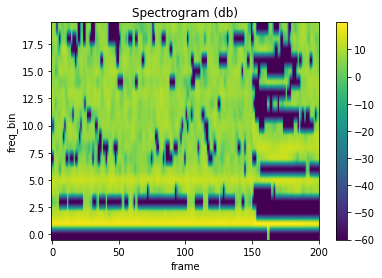

[2, 21, 7, 22, 24, 11, 7, 6, 14, 3]
torch.Size([64, 20, 201])
torch.float32
torch.float32
tensor([ 2, 13,  8, 26,  3,  0,  0,  0,  0,  0]) <sos>six


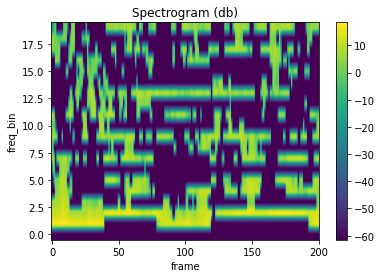

torch.Size([64, 20, 201])
torch.float32
torch.float32
tensor([ 2, 27,  4,  6,  5,  3,  0,  0,  0,  0]) <sos>zero


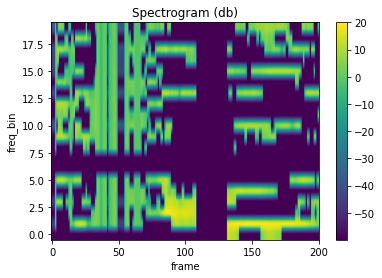

torch.Size([64, 20, 201])
torch.float32
torch.float32
tensor([ 2, 19, 20,  3,  0,  0,  0,  0,  0,  0]) <sos>up


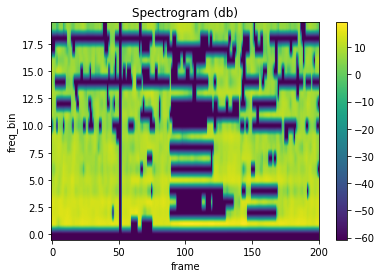

torch.Size([64, 20, 201])
torch.float32
torch.float32
tensor([2, 5, 9, 3, 0, 0, 0, 0, 0, 0]) <sos>on


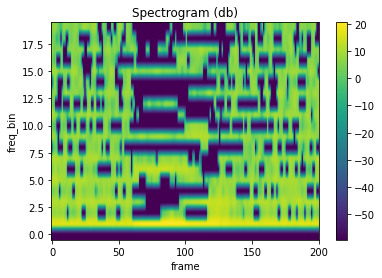

torch.Size([64, 20, 201])
torch.float32
torch.float32
tensor([ 2, 15,  7, 20, 20, 23,  3,  0]) <sos>happy


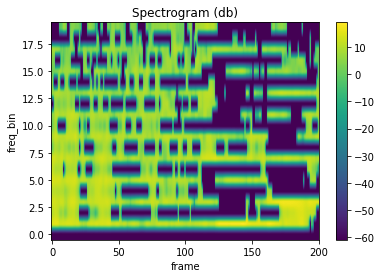

torch.Size([64, 20, 201])
torch.float32
torch.float32
tensor([ 2, 16,  4, 12, 10,  3,  0,  0,  0,  0]) <sos>left


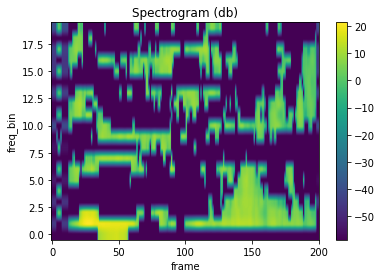

torch.Size([64, 20, 201])
torch.float32
torch.float32
tensor([2, 5, 9, 4, 3, 0, 0, 0, 0, 0]) <sos>one


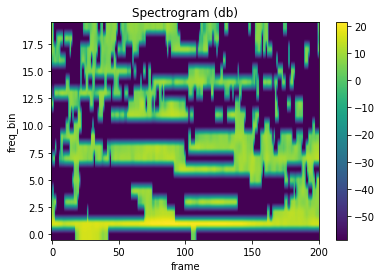

torch.Size([64, 20, 201])
torch.float32
torch.float32
tensor([2, 5, 9, 4, 3, 0, 0, 0, 0, 0]) <sos>one


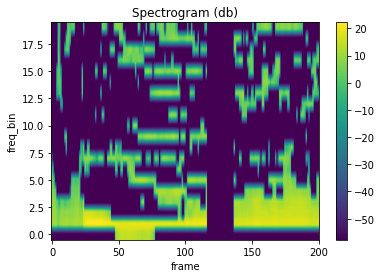

torch.Size([64, 20, 201])
torch.float32
torch.float32
tensor([2, 5, 9, 4, 3, 0, 0, 0, 0, 0]) <sos>one


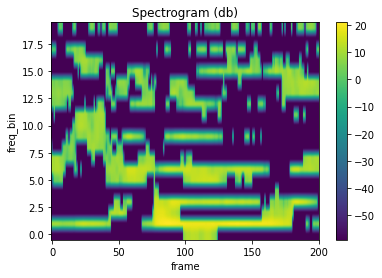

torch.Size([64, 20, 201])
torch.float32
torch.float32
tensor([ 2, 25,  7,  6, 18,  8,  9,  3,  0,  0]) <sos>marvin


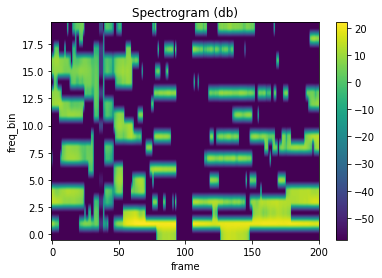

torch.Size([64, 20, 201])
torch.float32
torch.float32
tensor([ 2, 12,  8, 18,  4,  3,  0,  0]) <sos>five


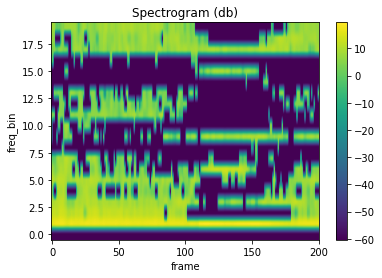

In [55]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

plot_spectrogram(train_dataset.__getitem__(0)[0])
print(train_dataset.__getitem__(0)[1])

for i, (data) in enumerate(train_dataloader):
    specs, targets, *_ = data
    print(specs.shape)
    print(specs.dtype)
    augmented_specs = specAug(specs)
    print(augmented_specs.dtype)
    print(targets[0], label_to_string(targets[0]))
    plot_spectrogram(augmented_specs[0])
    if i==10:
        break

# Squeezeformer

## Activations

In [56]:
class Swish(nn.Module):
    def __init__(self) -> None:
        super(Swish, self).__init__()

    def forward(self, inputs: Tensor) -> Tensor:
        return inputs * inputs.sigmoid()


class GLU(nn.Module):
    def __init__(self, dim: int) -> None:
        super(GLU, self).__init__()
        self.dim = dim

    def forward(self, inputs: Tensor) -> Tensor:
        outputs, gate = inputs.chunk(2, dim=self.dim)
        return outputs * gate.sigmoid()


## Modules

In [57]:
class FeedForwardModule(nn.Module):
    """
    Feed Forward Module follow pre-norm residual units and apply layer normalization within the residual unit
    and on the input before the first linear layer. This module also apply Swish activation and dropout, which helps
    regularizing the network.

    Args:
        encoder_dim (int): Dimension of squeezeformer encoder
        expansion_factor (int): Expansion factor of feed forward module.
        dropout_p (float): Ratio of dropout
    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor contains input sequences
    Outputs: outputs
        - **outputs** (batch, time, dim): Tensor produces by feed forward module.
    """

    def __init__(
        self,
        encoder_dim: int = 512,
        expansion_factor: int = 4,
        dropout_p: float = 0.1,
    ) -> None:
        super(FeedForwardModule, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(encoder_dim, encoder_dim * expansion_factor, bias=True),
            Swish(),
            nn.Dropout(p=dropout_p),
            nn.Linear(encoder_dim * expansion_factor, encoder_dim, bias=True),
            nn.Dropout(p=dropout_p),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.sequential(inputs)


class RelPositionalEncoding(nn.Module):
    """
    Relative positional encoding module.
    Args:
        d_model: Embedding dimension.
        max_len: Maximum input length.
    """

    def __init__(self, d_model: int = 512, max_len: int = 5000) -> None:
        super(RelPositionalEncoding, self).__init__()
        self.d_model = d_model
        self.pe = None
        self.extend_pe(torch.tensor(0.0).expand(1, max_len))

    def extend_pe(self, x):
        if self.pe is not None:
            if self.pe.size(1) >= x.size(1) * 2 - 1:
                if self.pe.dtype != x.dtype or self.pe.device != x.device:
                    self.pe = self.pe.to(dtype=x.dtype, device=x.device)
                return

        pe_positive = torch.zeros(x.size(1), self.d_model)
        pe_negative = torch.zeros(x.size(1), self.d_model)
        position = torch.arange(0, x.size(1), dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, self.d_model, 2, dtype=torch.float32) * -(math.log(10000.0) / self.d_model)
        )
        pe_positive[:, 0::2] = torch.sin(position * div_term)
        pe_positive[:, 1::2] = torch.cos(position * div_term)
        pe_negative[:, 0::2] = torch.sin(-1 * position * div_term)
        pe_negative[:, 1::2] = torch.cos(-1 * position * div_term)

        pe_positive = torch.flip(pe_positive, [0]).unsqueeze(0)
        pe_negative = pe_negative[1:].unsqueeze(0)
        pe = torch.cat([pe_positive, pe_negative], dim=1)
        self.pe = pe.to(device=x.device, dtype=x.dtype)

    def forward(self, x: torch.Tensor):
        """
        Args:
            x : Input tensor B X T X C
        Returns:
            torch.Tensor: Encoded tensor B X T X C
        """
        self.extend_pe(x)
        pos_emb = self.pe[
            :,
            self.pe.size(1) // 2 - x.size(1) + 1 : self.pe.size(1) // 2 + x.size(1),
        ]
        return pos_emb


class ResidualConnectionModule(nn.Module):
    """
    Residual Connection Module.
    outputs = (module(inputs) x module_factor + inputs x input_factor)
    """

    def __init__(self, module: nn.Module, module_factor: float = 1.0) -> None:
        super(ResidualConnectionModule, self).__init__()
        self.module = module
        self.module_factor = module_factor

    def forward(self, inputs: Tensor) -> Tensor:
        return (self.module(inputs) * self.module_factor) + inputs


class Transpose(nn.Module):
    """Wrapper class of torch.transpose() for Sequential module."""

    def __init__(self, shape: tuple) -> None:
        super(Transpose, self).__init__()
        self.shape = shape

    def forward(self, x: Tensor) -> Tensor:
        return x.transpose(*self.shape)


def recover_resolution(inputs: Tensor) -> Tensor:
    outputs = list()

    for idx in range(inputs.size(1) * 2):
        outputs.append(inputs[:, idx // 2, :])
    return torch.stack(outputs, dim=1)


## Convolution

In [58]:
class DepthwiseConv2dSubsampling(nn.Module):
    """
    Depthwise Convolutional 2D subsampling (to 1/4 length)

    Args:
        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the convolution
    Inputs: inputs, input_lengths
        - **inputs** (batch, time, dim): Tensor containing sequence of inputs
        - **input_lengths** (batch): list of sequence input lengths
    Returns: outputs, output_lengths
        - **outputs** (batch, time, dim): Tensor produced by the convolution
        - **output_lengths** (batch): list of sequence output lengths
    """

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(DepthwiseConv2dSubsampling, self).__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2),
            nn.ReLU(),
            DepthwiseConv2d(out_channels, out_channels, kernel_size=3, stride=2),
            nn.ReLU(),
        )

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        outputs = self.sequential(inputs.unsqueeze(1))
        batch_size, channels, subsampled_lengths, subsampled_dim = outputs.size()

        outputs = outputs.permute(0, 2, 1, 3)
        outputs = outputs.contiguous().view(batch_size, subsampled_lengths, channels * subsampled_dim)

        output_lengths = input_lengths >> 2
        output_lengths -= 1

        return outputs, output_lengths


class DepthwiseConv2d(nn.Module):
    """
    When groups == in_channels and out_channels == K * in_channels, where K is a positive integer,
    this operation is termed in literature as depthwise convolution.
    ref : https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

    Args:
        in_channels (int): Number of channels in the input
        out_channels (int): Number of channels produced by the convolution
        kernel_size (int or tuple): Size of the convolving kernel
        stride (int, optional): Stride of the convolution. Default: 2
        padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
    Inputs: inputs
        - **inputs** (batch, in_channels, time): Tensor containing input vector
    Returns: outputs
        - **outputs** (batch, out_channels, time): Tensor produces by depthwise 2-D convolution.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Tuple],
        stride: int = 2,
        padding: int = 0,
    ) -> None:
        super(DepthwiseConv2d, self).__init__()
        assert out_channels % in_channels == 0, "out_channels should be constant multiple of in_channels"
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=in_channels,
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.conv(inputs)


class DepthwiseConv1d(nn.Module):
    """
    When groups == in_channels and out_channels == K * in_channels, where K is a positive integer,
    this operation is termed in literature as depthwise convolution.
    ref : https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

    Args:
        in_channels (int): Number of channels in the input
        out_channels (int): Number of channels produced by the convolution
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        bias (bool, optional): If True, adds a learnable bias to the output. Default: False
    Inputs: inputs
        - **inputs** (batch, in_channels, time): Tensor containing input vector
    Returns: outputs
        - **outputs** (batch, out_channels, time): Tensor produces by depthwise 1-D convolution.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        padding: int = 0,
        bias: bool = False,
    ) -> None:
        super(DepthwiseConv1d, self).__init__()
        assert out_channels % in_channels == 0, "out_channels should be constant multiple of in_channels"
        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            groups=in_channels,
            stride=stride,
            padding=padding,
            bias=bias,
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.conv(inputs)


class PointwiseConv1d(nn.Module):
    """
    When kernel size == 1 conv1d, this operation is termed in literature as pointwise convolution.
    This operation often used to match dimensions.

    Args:
        in_channels (int): Number of channels in the input
        out_channels (int): Number of channels produced by the convolution
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        bias (bool, optional): If True, adds a learnable bias to the output. Default: True
    Inputs: inputs
        - **inputs** (batch, in_channels, time): Tensor containing input vector
    Returns: outputs
        - **outputs** (batch, out_channels, time): Tensor produces by pointwise 1-D convolution.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        padding: int = 0,
        bias: bool = True,
    ) -> None:
        super(PointwiseConv1d, self).__init__()
        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=stride,
            padding=padding,
            bias=bias,
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.conv(inputs)


class ConvModule(nn.Module):
    """
    Convolution module starts with a pointwise convolution and a gated linear unit (GLU).
    This is followed by a single 1-D depthwise convolution layer. Batchnorm is deployed just after the convolution
    to aid training deep models.

    Args:
        in_channels (int): Number of channels in the input
        kernel_size (int or tuple, optional): Size of the convolving kernel Default: 31
        dropout_p (float, optional): probability of dropout
    Inputs: inputs
        inputs (batch, time, dim): Tensor contains input sequences
    Outputs: outputs
        outputs (batch, time, dim): Tensor produces by squeezeformer convolution module.
    """

    def __init__(
        self,
        in_channels: int,
        kernel_size: int = 31,
        expansion_factor: int = 2,
        dropout_p: float = 0.1,
    ) -> None:
        super(ConvModule, self).__init__()
        assert (kernel_size - 1) % 2 == 0, "kernel_size should be a odd number for 'SAME' padding"
        assert expansion_factor == 2, "Currently, Only Supports expansion_factor 2"

        self.sequential = nn.Sequential(
            Transpose(shape=(1, 2)),
            PointwiseConv1d(in_channels, in_channels * expansion_factor, stride=1, padding=0, bias=True),
            GLU(dim=1),
            DepthwiseConv1d(in_channels, in_channels, kernel_size, stride=1, padding=(kernel_size - 1) // 2),
            nn.BatchNorm1d(in_channels),
            Swish(),
            PointwiseConv1d(in_channels, in_channels, stride=1, padding=0, bias=True),
            nn.Dropout(p=dropout_p),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.sequential(inputs).transpose(1, 2)


class TimeReductionLayer(nn.Module):
    def __init__(
        self,
        in_channels: int = 1,
        out_channels: int = 1,
        kernel_size: int = 3,
        stride: int = 2,
    ) -> None:
        super(TimeReductionLayer, self).__init__()
        self.sequential = nn.Sequential(
            DepthwiseConv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
            ),
            Swish(),
        )

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        outputs = self.sequential(inputs.unsqueeze(1))
        batch_size, channels, subsampled_lengths, subsampled_dim = outputs.size()

        outputs = outputs.permute(0, 2, 1, 3)
        outputs = outputs.contiguous().view(batch_size, subsampled_lengths, channels * subsampled_dim)

        output_lengths = input_lengths >> 1
        output_lengths -= 1
        return outputs, output_lengths


## Attention

In [59]:
class RelativeMultiHeadAttention(nn.Module):
    """
    Multi-head attention with relative positional encoding.
    This concept was proposed in the "Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context"
    Args:
        d_model (int): The dimension of model
        num_heads (int): The number of attention heads.
        dropout_p (float): probability of dropout
    Inputs: query, key, value, pos_embedding, mask
        - **query** (batch, time, dim): Tensor containing query vector
        - **key** (batch, time, dim): Tensor containing key vector
        - **value** (batch, time, dim): Tensor containing value vector
        - **pos_embedding** (batch, time, dim): Positional embedding tensor
        - **mask** (batch, 1, time2) or (batch, time1, time2): Tensor containing indices to be masked
    Returns:
        - **outputs**: Tensor produces by relative multi head attention module.
    """

    def __init__(
        self,
        d_model: int = 512,
        num_heads: int = 16,
        dropout_p: float = 0.1,
    ):
        super(RelativeMultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model % num_heads should be zero."
        self.d_model = d_model
        self.d_head = int(d_model / num_heads)
        self.num_heads = num_heads
        self.sqrt_dim = math.sqrt(self.d_head)

        self.query_proj = nn.Linear(d_model, d_model)
        self.key_proj = nn.Linear(d_model, d_model)
        self.value_proj = nn.Linear(d_model, d_model)
        self.pos_proj = nn.Linear(d_model, d_model, bias=False)

        self.dropout = nn.Dropout(p=dropout_p)
        self.u_bias = nn.Parameter(torch.Tensor(self.num_heads, self.d_head))
        self.v_bias = nn.Parameter(torch.Tensor(self.num_heads, self.d_head))
        torch.nn.init.xavier_uniform_(self.u_bias)
        torch.nn.init.xavier_uniform_(self.v_bias)

        self.out_proj = nn.Linear(d_model, d_model)

    def forward(
        self,
        query: Tensor,
        key: Tensor,
        value: Tensor,
        pos_embedding: Tensor,
        mask: Optional[Tensor] = None,
    ) -> Tensor:
        batch_size = value.size(0)

        query = self.query_proj(query).view(batch_size, -1, self.num_heads, self.d_head)
        key = self.key_proj(key).view(batch_size, -1, self.num_heads, self.d_head).permute(0, 2, 1, 3)
        value = self.value_proj(value).view(batch_size, -1, self.num_heads, self.d_head).permute(0, 2, 1, 3)
        pos_embedding = self.pos_proj(pos_embedding).view(batch_size, -1, self.num_heads, self.d_head)

        content_score = torch.matmul((query + self.u_bias).transpose(1, 2), key.transpose(2, 3))
        pos_score = torch.matmul((query + self.v_bias).transpose(1, 2), pos_embedding.permute(0, 2, 3, 1))
        pos_score = self._relative_shift(pos_score)

        score = (content_score + pos_score) / self.sqrt_dim

        if mask is not None:
            mask = mask.unsqueeze(1)
            score.masked_fill_(mask, -1e9)

        attn = F.softmax(score, -1)
        attn = self.dropout(attn)

        context = torch.matmul(attn, value).transpose(1, 2)
        context = context.contiguous().view(batch_size, -1, self.d_model)

        return self.out_proj(context)

    def _relative_shift(self, pos_score: Tensor) -> Tensor:
        batch_size, num_heads, seq_length1, seq_length2 = pos_score.size()
        zeros = pos_score.new_zeros(batch_size, num_heads, seq_length1, 1)
        padded_pos_score = torch.cat([zeros, pos_score], dim=-1)

        padded_pos_score = padded_pos_score.view(batch_size, num_heads, seq_length2 + 1, seq_length1)
        pos_score = padded_pos_score[:, :, 1:].view_as(pos_score)[:, :, :, : seq_length2 // 2 + 1]

        return pos_score


class MultiHeadedSelfAttentionModule(nn.Module):
    """
    Args:
        d_model (int): The dimension of model
        num_heads (int): The number of attention heads.
        dropout_p (float): probability of dropout
    Inputs: inputs, mask
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **mask** (batch, 1, time2) or (batch, time1, time2): Tensor containing indices to be masked
    Returns:
        - **outputs** (batch, time, dim): Tensor produces by relative multi headed self attention module.
    """

    def __init__(self, d_model: int, num_heads: int, dropout_p: float = 0.1):
        super(MultiHeadedSelfAttentionModule, self).__init__()
        self.positional_encoding = RelPositionalEncoding(d_model)
        self.attention = RelativeMultiHeadAttention(d_model, num_heads, dropout_p)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, inputs: Tensor, mask: Optional[Tensor] = None):
        batch_size = inputs.size(0)
        pos_embedding = self.positional_encoding(inputs)
        pos_embedding = pos_embedding.repeat(batch_size, 1, 1)

        outputs = self.attention(inputs, inputs, inputs, pos_embedding=pos_embedding, mask=mask)

        return self.dropout(outputs)


## SqueezeformerBlock

In [60]:
class SqueezeformerBlock(nn.Module):
    """
    SqueezeformerBlock is a simpler block structure similar to the standard Transformer block,
    where the MHA and convolution modules are each directly followed by a single feed forward module.

    Args:
        encoder_dim (int, optional): Dimension of squeezeformer encoder
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of squeezeformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of squeezeformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not
    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing input vector
    Returns: outputs
        - **outputs** (batch, time, dim): Tensor produces by squeezeformer block.
    """

    def __init__(
        self,
        encoder_dim: int = 512,
        num_attention_heads: int = 8,
        feed_forward_expansion_factor: int = 4,
        conv_expansion_factor: int = 2,
        feed_forward_dropout_p: float = 0.1,
        attention_dropout_p: float = 0.1,
        conv_dropout_p: float = 0.1,
        conv_kernel_size: int = 31,
        half_step_residual: bool = False,
    ):
        super(SqueezeformerBlock, self).__init__()
        if half_step_residual:
            self.feed_forward_residual_factor = 0.5
        else:
            self.feed_forward_residual_factor = 1.0

        self.sequential = nn.Sequential(
            ResidualConnectionModule(
                module=MultiHeadedSelfAttentionModule(
                    d_model=encoder_dim,
                    num_heads=num_attention_heads,
                    dropout_p=attention_dropout_p,
                ),
            ),
            nn.LayerNorm(encoder_dim),
            ResidualConnectionModule(
                module=FeedForwardModule(
                    encoder_dim=encoder_dim,
                    expansion_factor=feed_forward_expansion_factor,
                    dropout_p=feed_forward_dropout_p,
                ),
                module_factor=self.feed_forward_residual_factor,
            ),
            nn.LayerNorm(encoder_dim),
            ResidualConnectionModule(
                module=ConvModule(
                    in_channels=encoder_dim,
                    kernel_size=conv_kernel_size,
                    expansion_factor=conv_expansion_factor,
                    dropout_p=conv_dropout_p,
                ),
            ),
            nn.LayerNorm(encoder_dim),
            ResidualConnectionModule(
                module=FeedForwardModule(
                    encoder_dim=encoder_dim,
                    expansion_factor=feed_forward_expansion_factor,
                    dropout_p=feed_forward_dropout_p,
                ),
                module_factor=self.feed_forward_residual_factor,
            ),
            nn.LayerNorm(encoder_dim),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.sequential(inputs)


## Encoder

In [61]:
class SqueezeformerEncoder(nn.Module):
    """
    Squeezeformer encoder first processes the input with a convolution subsampling layer and then
    with a number of squeezeformer blocks.

    Args:
        input_dim (int, optional): Dimension of input vector
        encoder_dim (int, optional): Dimension of squeezeformer encoder
        num_layers (int, optional): Number of squeezeformer blocks
        reduce_layer_index (int, optional): The layer index to reduce sequence length
        recover_layer_index (int, optional): The layer index to recover sequence length
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of squeezeformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of squeezeformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not
    Inputs: inputs, input_lengths
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **input_lengths** (batch): list of sequence input lengths
    Returns: outputs, output_lengths
        - **outputs** (batch, out_channels, time): Tensor produces by squeezeformer encoder.
        - **output_lengths** (batch): list of sequence output lengths
    """

    def __init__(
        self,
        input_dim: int = 80,
        encoder_dim: int = 512,
        num_layers: int = 16,
        reduce_layer_index: int = 7,
        recover_layer_index: int = 15,
        num_attention_heads: int = 8,
        feed_forward_expansion_factor: int = 4,
        conv_expansion_factor: int = 2,
        input_dropout_p: float = 0.1,
        feed_forward_dropout_p: float = 0.1,
        attention_dropout_p: float = 0.1,
        conv_dropout_p: float = 0.1,
        conv_kernel_size: int = 31,
        half_step_residual: bool = False,
    ):
        super(SqueezeformerEncoder, self).__init__()
        self.num_layers = num_layers
        self.reduce_layer_index = reduce_layer_index
        self.recover_layer_index = recover_layer_index
        self.conv_subsample = DepthwiseConv2dSubsampling(in_channels=1, out_channels=encoder_dim)
        self.input_proj = nn.Sequential(
            nn.Linear(encoder_dim * (((input_dim - 1) // 2 - 1) // 2), encoder_dim),
            nn.Dropout(p=input_dropout_p),
        )
        self.time_reduction_layer = TimeReductionLayer()
        self.time_reduction_proj = nn.Linear((encoder_dim - 1) // 2, encoder_dim)
        self.time_recover_layer = nn.Linear(encoder_dim, encoder_dim)
        self.recover_tensor = None

        self.layers = nn.ModuleList()
        for idx in range(num_layers):
            if idx < reduce_layer_index:
                self.layers.append(
                    SqueezeformerBlock(
                        encoder_dim=encoder_dim,
                        num_attention_heads=num_attention_heads,
                        feed_forward_expansion_factor=feed_forward_expansion_factor,
                        conv_expansion_factor=conv_expansion_factor,
                        feed_forward_dropout_p=feed_forward_dropout_p,
                        attention_dropout_p=attention_dropout_p,
                        conv_dropout_p=conv_dropout_p,
                        conv_kernel_size=conv_kernel_size,
                        half_step_residual=half_step_residual,
                    )
                )
            elif reduce_layer_index <= idx < recover_layer_index:
                self.layers.append(
                    ResidualConnectionModule(
                        module=SqueezeformerBlock(
                            encoder_dim=encoder_dim,
                            num_attention_heads=num_attention_heads,
                            feed_forward_expansion_factor=feed_forward_expansion_factor,
                            conv_expansion_factor=conv_expansion_factor,
                            feed_forward_dropout_p=feed_forward_dropout_p,
                            attention_dropout_p=attention_dropout_p,
                            conv_dropout_p=conv_dropout_p,
                            conv_kernel_size=conv_kernel_size,
                            half_step_residual=half_step_residual,
                        )
                    )
                )
            else:
                self.layers.append(
                    SqueezeformerBlock(
                        encoder_dim=encoder_dim,
                        num_attention_heads=num_attention_heads,
                        feed_forward_expansion_factor=feed_forward_expansion_factor,
                        conv_expansion_factor=conv_expansion_factor,
                        feed_forward_dropout_p=feed_forward_dropout_p,
                        attention_dropout_p=attention_dropout_p,
                        conv_dropout_p=conv_dropout_p,
                        conv_kernel_size=conv_kernel_size,
                        half_step_residual=half_step_residual,
                    )
                )

    def count_parameters(self) -> int:
        """Count parameters of encoder"""
        return sum([p.numel for p in self.parameters()])

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Forward propagate a `inputs` for  encoder training.
        Args:
            inputs (torch.FloatTensor): A input sequence passed to encoder. Typically for inputs this will be a padded
                `FloatTensor` of size ``(batch, seq_length, dimension)``.
            input_lengths (torch.LongTensor): The length of input tensor. ``(batch)``
        Returns:
            (Tensor, Tensor)
            * outputs (torch.FloatTensor): A output sequence of encoder. `FloatTensor` of size
                ``(batch, seq_length, dimension)``
            * output_lengths (torch.LongTensor): The length of output tensor. ``(batch)``
        """
        outputs, output_lengths = self.conv_subsample(inputs, input_lengths)
        outputs = self.input_proj(outputs)

        for idx, layer in enumerate(self.layers):
            if idx == self.reduce_layer_index:
                self.recover_tensor = outputs
                outputs, output_lengths = self.time_reduction_layer(outputs, output_lengths)
                outputs = self.time_reduction_proj(outputs)

            if idx == self.recover_layer_index:
                outputs = recover_resolution(outputs)
                length = outputs.size(1)
                outputs = self.time_recover_layer(outputs)
                outputs += self.recover_tensor[:, :length, :]
                output_lengths *= 2

            outputs = layer(outputs)

        return outputs, output_lengths


## Squeezeformer

In [62]:
class Squeezeformer(nn.Module):
    """
    Squeezeformer incorporates the Temporal U-Net structure, which reduces the cost of the
    multi-head attention modules on long sequences, and a simpler block structure of feed-forward module,
    followed up by multi-head attention or convolution modules,
    instead of the Macaron structure proposed in Conformer.

    Args:
        num_classes (int): Number of classification classes
        input_dim (int, optional): Dimension of input vector
        encoder_dim (int, optional): Dimension of squeezeformer encoder
        num_encoder_layers (int, optional): Number of squeezeformer blocks
        reduce_layer_index (int, optional): The layer index to reduce sequence length
        recover_layer_index (int, optional): The layer index to recover sequence length
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of squeezeformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of squeezeformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not
    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **input_lengths** (batch): list of sequence input lengths
    Returns: outputs, output_lengths
        - **outputs** (batch, out_channels, time): Tensor produces by squeezeformer.
        - **output_lengths** (batch): list of sequence output lengths
    """

    def __init__(
        self,
        num_classes: int,
        input_dim: int = 80,
        encoder_dim: int = 512,
        num_encoder_layers: int = 16,
        reduce_layer_index: int = 7,
        recover_layer_index: int = 15,
        num_attention_heads: int = 8,
        feed_forward_expansion_factor: int = 4,
        conv_expansion_factor: int = 2,
        input_dropout_p: float = 0.1,
        feed_forward_dropout_p: float = 0.1,
        attention_dropout_p: float = 0.1,
        conv_dropout_p: float = 0.1,
        conv_kernel_size: int = 31,
        half_step_residual: bool = False,
    ) -> None:
        super(Squeezeformer, self).__init__()
        self.encoder = SqueezeformerEncoder(
            input_dim=input_dim,
            encoder_dim=encoder_dim,
            num_layers=num_encoder_layers,
            reduce_layer_index=reduce_layer_index,
            recover_layer_index=recover_layer_index,
            num_attention_heads=num_attention_heads,
            feed_forward_expansion_factor=feed_forward_expansion_factor,
            conv_expansion_factor=conv_expansion_factor,
            input_dropout_p=input_dropout_p,
            feed_forward_dropout_p=feed_forward_dropout_p,
            attention_dropout_p=attention_dropout_p,
            conv_dropout_p=conv_dropout_p,
            conv_kernel_size=conv_kernel_size,
            half_step_residual=half_step_residual,
        )
        self.fc = nn.Linear(encoder_dim, num_classes, bias=False)

    def count_parameters(self) -> int:
        """Count parameters of encoder"""
        return self.encoder.count_parameters()

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Forward propagate a `inputs` and `targets` pair for training.
        Args:
            inputs (torch.FloatTensor): A input sequence passed to encoder. Typically for inputs this will be a padded
                `FloatTensor` of size ``(batch, seq_length, dimension)``.
            input_lengths (torch.LongTensor): The length of input tensor. ``(batch)``
        Returns:
            * predictions (torch.FloatTensor): Result of model predictions.
        """
        encoder_outputs, encoder_output_lengths = self.encoder(inputs, input_lengths)
        outputs = self.fc(encoder_outputs)
        outputs = F.log_softmax(outputs, dim=-1)
        return outputs, encoder_output_lengths


# Train function

In [63]:
def train(batch_idx, model, data, criterion, optimizer, device):
    total_loss = 0.
    total_num = 0
    total_dist = 0
    total_length = 0

    feats, targets, feat_lengths, targets_lengths = data
    feats = specAug(feats)
    feats = torch.FloatTensor(feats)
    feats=feats.permute(0,2,1)
    feats = feats.to(device) 
    targets = targets.to(device)

    model.train()
    optimizer.zero_grad()
    
    logit, output_lengths = model(feats, feat_lengths)

    target = targets[:, 1:]

    # Loss 계산
    logit = logit.transpose(0,1)
    output_lengths = torch.IntTensor(output_lengths)
    targets_lengths = torch.IntTensor(targets_lengths)-1

    loss = criterion(logit, target, output_lengths, targets_lengths)

    #학습
    loss.backward() 
    optimizer.step()

    total_loss += loss.item()
    total_num += sum(feat_lengths)
    loss = total_loss / total_num

    # cer 계산
    y_hat = logit.max(-1)[1] # 가장 큰 클래스의 위치를 나타냄.
    y_hat = y_hat.transpose(0,1)
    dist, length = get_distance(target, y_hat)
    total_dist += dist
    total_length += length
    cer = total_dist / total_length

    if batch_idx % 50 == 0 :
        print(label_to_string_hyp(y_hat[0]), '-', label_to_string(target[0]))

    return loss.item(),cer

# Evaluation function

In [64]:
def evaluate(batch_idx, model, data, criterion, device):

    total_loss = 0.
    total_num = 0
    total_dist = 0
    total_length = 0

    feats, targets, feat_lengths, targets_lengths = data
    feats=feats.permute(0,2,1)
    feats = feats.to(device) 
    targets = targets.to(device)

    model.eval()

    #변화도(gradient)는 필요없지만, requires_grad=True 가 설정되어 학습 가능한 매개변수를 갖는 모델을 평가(evaluate)
    with torch.no_grad():
        logit, output_lengths = model(feats, feat_lengths)

        target = targets[:, 1:]  
        
        # Loss 계산
        logit = logit.transpose(0,1)
        output_lengths = torch.IntTensor(output_lengths)
        targets_lengths = torch.IntTensor(targets_lengths)-1
        loss = criterion(logit, target, output_lengths, targets_lengths)

        
        total_loss += loss.item()
        total_num += sum(feat_lengths)
        loss = total_loss / total_num

        # cer 계산
        y_hat = logit.max(-1)[1]
        y_hat = y_hat.transpose(0,1)
        dist, length = get_distance(target, y_hat)
        total_dist += dist
        total_length += length
        cer = total_dist / total_length

        # 50마다 배치 첫번째 결과 출력
        if batch_idx % 50 == 0 :
            print(label_to_string_hyp(y_hat[0]), '-', label_to_string(target[0]))
        
    return loss.item(),cer
    

# main

## model 선언

In [65]:
model = Squeezeformer(num_classes = len(config.index2char),
                    input_dim=config.input_dim,
                    encoder_dim=config.encoder_dim,
                    num_encoder_layers=config.num_encoder_layers,
                    num_attention_heads=config.num_attention_heads,
                    feed_forward_expansion_factor=config.feed_forward_expansion_factor,
                    conv_expansion_factor=config.conv_expansion_factor,
                    input_dropout_p=config.input_dropout_p,
                    feed_forward_dropout_p=config.feed_forward_dropout_p,
                    attention_dropout_p=config.attention_dropout_p,
                    conv_dropout_p=config.conv_dropout_p,
                    conv_kernel_size=config.conv_kernel_size,
                    half_step_residual=config.half_step_residual,
                    )
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=config.lr, weight_decay = config.weight_decay)
criterion = nn.CTCLoss().to(device)

## train

In [66]:
# 끊긴걸 이어서 학습하는 경우 (제출시에는 지울 것)
if config.saved_json:
    dd = loadjson(config.saved_json)
    train_losses = dd["train_losses"]
    train_cers = dd["train_cers"]
    test_losses = dd["test_losses"]
    test_cers = dd["test_cers"]
else:
    train_losses = []
    train_cers = []
    test_losses = []
    test_cers = []

if config.last_model:
    model = torch.load(config.last_model)
    model.to(device)
if config.best_loss_model:
    best_loss_model = torch.load(config.best_loss_model)
    best_loss_model.to(device)
if config.best_cer_model:
    best_cer_model = torch.load(config.best_cer_model)
    best_cer_model.to(device)

- 개선 없으면 중간에 학습 멈춰도 됨!
- 대신 뒤에 이어지는 testset 검증 코드도 바로 실행해볼것.

In [ ]:
#---------------------------------------------학습 시작---------------------------------------------------------------------------#
len_train_dataloader =  len(train_dataloader)
len_val_dataloader =  len(valid_dataloader)

best_eval_loss = 100
best_eval_cer = 100

LOSS_NOT_IMPROVED = 0
CER_NOT_IMPROVED = 0

for epoch in range(config.start_epoch, config.max_epoch+1):
    Total_train_loss, Total_train_cer = 0,0
    Total_eval_loss, Total_eval_cer = 0,0

    try:
        # train
        for batch_idx, data in tqdm(enumerate(train_dataloader), desc=' Train batch', total= len_train_dataloader):
            train_batch_loss, train_batch_cer = train(batch_idx, model, data, criterion, optimizer, device)

            Total_train_loss += train_batch_loss
            Total_train_cer += train_batch_cer

        Total_train_loss = Total_train_loss/len_train_dataloader
        Total_train_cer = Total_train_cer/len_train_dataloader

        train_losses.append(Total_train_loss)
        train_cers.append(Total_train_cer)

        print("(train) epoch {} Loss {} CER {}".format(epoch,Total_train_loss,Total_train_cer) )

        # validation
        for batch_idx, data in tqdm(enumerate(valid_dataloader), desc='Val batch',  total= len_val_dataloader):
            eval_batch_loss, eval_batch_cer = evaluate(batch_idx, model, data, criterion, device)

            Total_eval_loss += eval_batch_loss
            Total_eval_cer += eval_batch_cer

        Total_eval_loss /= len_val_dataloader
        Total_eval_cer /= len_val_dataloader

        test_losses.append(Total_eval_loss)
        test_cers.append(Total_eval_cer)

        print("(eval) epoch {} / Loss {} / CER {}".format(epoch, Total_eval_loss, Total_eval_cer))

        # 가장 최근 모델 저장
        recent_model_path = get_save_path(f"{config.training_id}_recent_model.pt")
        torch.save(model, recent_model_path)

        # train/test loss/cer 을 JSON과 plot으로 저장
        loss_cer_json = {"train_losses":train_losses,"train_cers":train_cers,"test_losses":test_losses,"test_cers":test_cers}
        writejson(get_save_path(f"{config.training_id}_train_test_loss_cer.json"),loss_cer_json)
        save_fig([train_losses,test_losses],['train_loss','test_loss'],get_save_path(f'{config.training_id}_plot_loss.png'))
        save_fig([train_cers,test_cers],['train_cer','test_cer'],get_save_path(f'{config.training_id}_plot_cer.png'))
        
        # loss가 가장 낮게 나온 경우의 모델 저장
        if Total_eval_loss < best_eval_loss:
            best_eval_loss = Total_eval_loss

            LOSS_NOT_IMPROVED = 0
        else:
            LOSS_NOT_IMPROVED += 1
            if LOSS_NOT_IMPROVED >= config.LOSS_TOLERANCE:
                break

        # CER이 가장 낮게 나온 경우의 모델 저장
        if Total_eval_cer < best_eval_cer:
            best_eval_cer = Total_eval_cer

            best_cer_model = copy.deepcopy(model)
            best_cer_model_path = get_save_path(f"{config.training_id}_best_cer_model.pt")
            torch.save(best_cer_model, best_cer_model_path)

            CER_NOT_IMPROVED = 0
        else:
            CER_NOT_IMPROVED += 1
            if CER_NOT_IMPROVED >= config.CER_TOLERANCE:
                break


    except KeyboardInterrupt as k:
        print(k)
        break

 Train batch:   0%|          | 0/1653 [00:00<?, ?it/s]

bbbbrkxk<sos>bbbybkk<sos>bbbblbbrbbbbbbbbkbbbnnnn<sos><sos><sos>bbbb - one
 - off
 - no
o - up
oo - no
si - six
on - nine
fon - on
bivd - marvin
happy - happy
yeess - yes
ca - cat
hhappy - happy
on - on
wow - wow
fouwrrd - four
left - right
three - three
noo - no
forwaarrdd - forward
be - bed
follow - follow
eight - right
wow - wow
borward - forward
foollllow - follow
fow - follow
houee - down
six - six
foollllow - follow
foollllow - follow
right - right
zero - zero
four - four
(train) epoch 1 Loss 6.747632020052342e-05 CER 0.4144529529560753


Val batch:   0%|          | 0/156 [00:00<?, ?it/s]

rightt - right
ninne - nine
visuall - visual
off - off
(eval) epoch 1 / Loss 1.5388887445711727e-05 / CER 0.17792691527260646


 Train batch:   0%|          | 0/1653 [00:00<?, ?it/s]

gat - go
treee - tree
on - on
three - three
treee - three
uup - up
down - down
off - off
noo - no
one - one
one - one
sheila - sheila
four - follow
foollloww - follow
goo - go
eightt - eight
one - one
leftt - left
goo - go
two - two
go - bird
no - down


## Test
학습한 모델의 마지막 성능 평가 :

In [ ]:

# 데이터 로드

test_dataset = SpectrogramDataset(test_set,
                                    config.max_len,
                                    config.SOS_token, 
                                    config.EOS_token,
                                    config.char2index,
                                    normalize=True,
                                    SAflag=False)

test_dataloader = AudioDataLoader(dataset=test_dataset,
                                    shuffle=False,
                                    batch_size=config.batch_size,
                                    drop_last=False)

len_test_dataloader =  len(test_dataloader)

# 추론 for min cer
Total_test_loss, Total_test_cer = 0,0
for batch_idx, data in tqdm(enumerate(test_dataloader), desc=' Test batch',  total= len_test_dataloader):
    test_batch_loss, test_batch_cer = evaluate(batch_idx, best_cer_model, data, criterion, device)

    Total_test_loss += test_batch_loss
    Total_test_cer += test_batch_cer
   

Total_test_loss = Total_test_loss/len_test_dataloader
Total_test_cer = Total_test_cer/len_test_dataloader

print("(test-min CER) Loss {} / CER {}".format(Total_test_loss,Total_test_cer))

# logger setting
with open(get_save_path("config.txt"), "a") as f:
    f.write("(test-min CER) Loss {} / CER {}".format(Total_test_loss,Total_test_cer))